In [5]:
import os
import sys
import time
from datetime import date
from datetime import datetime
import time
import json
import platform

import stoneburner
#//*** Custom Functions:
#//*** mr_clean_text(input_series)
#//*** tokenize_series(input_series)
#//*** remove_stop_words(input_series)

# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
subreddits = ["wallstreetbets", "stocks", "wallstreetbetsOGs", "spacs", "investing", "pennystocks", "stockmarket", "options", "robinhoodpennystocks", "wallstreetbetsnew", "smallstreetbets"]
filepath = "./data/"
filename_suffix = "_comments.csv.zip"
#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [6]:
def build_all_comments(subreddit,filepath,filename_suffix,keep_cols=['created_utc','body']):
    import time
    
    start_time = time.time()

    #//*** Initialize Output dataframe
    output_df = pd.DataFrame()

    #//*** Load each Subreddit for Aggregation
    for subreddit in subreddits:
        #//*** Filepath + subreddit name + csv.zip
        input_filename = filepath+subreddit+filename_suffix

        print(f"Reading Compressed CSV: {input_filename}")

        #//*** Read Each DataFrame and combine with output_df
        output_df = pd.concat([output_df,pd.read_csv(input_filename,compression='zip' )])

    #//*** All Files read
    #//*** Reset the output_df index, since multiple indexes have been combined
    output_df.reset_index(drop=True, inplace=True)

    print(f"Files Loaded: {round(time.time()-start_time,2)}s")
    print(f"Total Records: {len(output_df)}")
    
    #//*** Ensure the body column is a string
    output_df['body'] = output_df['body'].astype('str')

    #//*** Convert UTC to date (not datetime)
    #//** Second pass goes from 12-21 to 4-19
    try:
        output_df['created_utc'] = output_df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
    except:
        print()

    #//*** Keep just date and body fields
    output_df = output_df[keep_cols]

    return output_df

def build_stocks(symbol,interval,targets):
    
    stock_df = pd.read_csv(f"./stocks/{symbol}_{interval}.csv.zip")
    stock_df
    
    if 'date' in stock_df.columns:
        stock_df['date'] = pd.to_datetime(stock_df['date'])
        stock_df = stock_df.rename(columns={'date':'time'})
    else:
        stock_df['time'] = pd.to_datetime(stock_df['time'])
    
    offset_targets = [1,2,3,4,5,6,7,8,9,10]

    for offset in targets:
        #//*** create a list of nan values of x length
        nan_list = list(np.empty( offset )* np.nan )

        #//*** Create target variable Price which is stocks + x columns in advance
        #//*** Takes the closing price starting at x and gets the remainder, this generates the offset
        #//*** nan_list fills the missing x values with nans
        stock_df[f'target_{offset}'] = list(stock_df['close'][offset:]) + nan_list 

    stock_df = stock_df[:offset*-1]
    
    #//*** Keeping this cool chunk of code as a reference
    #stock_df['time'] = stock_df['time'].apply(lambda x: x.timestamp())
    
    #//*** Remove Comments older than the first stock price
    #raw_df = raw_df[ raw_df['created_utc'] >= stock_df['time'].min() ]
    
    #//*** Remove Stock Prices older than the first Comments price
    #stock_df = stock_df[ stock_df['time'] >= raw_df['created_utc'].min() ]
    

    
    #//*** Reorder Comments by date
    raw_df.sort_values('created_utc',inplace=True,ignore_index=True)
    
    #//*** Reorder Stocks by date
    stock_df.sort_values('time',inplace=True, ignore_index=True)
    
    return stock_df
  
def group_dataframe_by_time(stock_df,cdf):
    groups = stock_df.groupby('time')

    #https://www.geeksforgeeks.org/how-to-iterate-over-dataframe-groups-in-python-pandas/
    key_list = list(groups.groups.keys())

    out_df = pd.DataFrame()

    start_time = time.time()
    comment_min_time = raw_df['created_utc'].min()
    comment_max_time = raw_df['created_utc'].max()
    min_index = 0
    start_time = time.time()
    print("Processing...")
    for x in range(len(key_list)-1):

        #//*** Get a single line of stocks as a dataframe
        loop_stocks_df = groups.get_group((key_list)[x]).copy()  

        t1 = groups.get_group((key_list)[x])['time'].iloc[0]
        t2 = groups.get_group((key_list)[x+1])['time'].iloc[0]

        #search through cdf to find comments that are between t1 and t2
        #if len(cdf[ (cdf['created_utc'] > t1) & (cdf['created_utc'] < t2) ]) > 0:
        #temp_df = cdf.iloc[min_index:]
        temp_df = cdf[(cdf['created_utc'] >= t1) & (cdf['created_utc'] < t2) ]

        if len(temp_df) == 0:
                #//*** No COmments on this Date
                loop_stocks_df['body'] = " "
                loop_stocks_df['comment_count'] = 0
        else:
            #print(temp_df.index[0])
            #print(temp_df.index[-1])
            #print(cdf.iloc[temp_df.index[0]:temp_df.index[-1]])
            temp_df = cdf.iloc[temp_df.index[0]:temp_df.index[-1]]
            #//*** Get all the body comments and combine them
            loop_stocks_df['body'] = " ".join(list(temp_df['body']))

            #//*** Get a comment count, BC IDK Y
            loop_stocks_df['comment_count'] = len(temp_df['body']) 

        #//*** Secret to speeding up algorithm. Get the Index value of the last item found -1. 
        #//*** When Searching above, start the search from this index. Seems to speed things up. Since we're skipping past elements that we've already found
        if len(temp_df) > 0: 
            min_index = temp_df.index[-1]



        #//*** Add the single line of loop_stocks_df to bin_df    
        out_df = pd.concat([out_df,loop_stocks_df])
            #print(loop_df.index)
            #print(loop_df)
            #cdf = cdf.drop(index=loop_df.index)
    print(f"Merge Built: {round(time.time()-start_time,2)}s")   
    return out_df

In [7]:
#//*** Get all Reddit Comments and merge into a single Collection

#process_tfidf = False

#//**** Aggregate comments into a single dataframe
raw_df = build_all_comments(subreddits,filepath,filename_suffix)

raw_df

#//*** Trim dataframe to start in January 20202-01-02
start_trim_date = pd.to_datetime("2020-01-02")
raw_df = raw_df[raw_df['created_utc'] >= start_trim_date]


Reading Compressed CSV: ./data/wallstreetbets_comments.csv.zip
Reading Compressed CSV: ./data/stocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsOGs_comments.csv.zip
Reading Compressed CSV: ./data/spacs_comments.csv.zip
Reading Compressed CSV: ./data/investing_comments.csv.zip
Reading Compressed CSV: ./data/pennystocks_comments.csv.zip
Reading Compressed CSV: ./data/stockmarket_comments.csv.zip
Reading Compressed CSV: ./data/options_comments.csv.zip
Reading Compressed CSV: ./data/robinhoodpennystocks_comments.csv.zip
Reading Compressed CSV: ./data/wallstreetbetsnew_comments.csv.zip
Reading Compressed CSV: ./data/smallstreetbets_comments.csv.zip
Files Loaded: 39.33s
Total Records: 4432533


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

#//**** Get all Stocks to Model
interval="daily"

#//*** Path to processed files

#//*** Path to the stock ticker JSON file
stock_ticker_filename = "./data/stock_tickers.json"

#//*** Convert Path to Mac formatting if needed
#if platform.system() == 'Darwin':
#    output_filename = output_filename.replace("\\","/")
#    stock_ticker_filename = stock_ticker_filename.replace("\\","/")

#//*** Load the Stock Tickers
f = open(stock_ticker_filename, "r")
symbols = json.loads(f.read())['symbols']

#symbols = ["amc"]
f.close()

#//*** Convert symbols to lower case
symbols = [x.lower() for x in symbols]

start_process_time = time.time()

for symbol in symbols:
    start_symbol_time = time.time()
    
    print("==========")
    print("==========")
    print("==========")
    print(f"Building {symbol} Targets...")
    #//*** Build stock price and target columns to predict
    stock_df = build_stocks(symbol,'daily',[1])  

    print(f"Dropping {symbol} dates before {start_trim_date}")
    stock_df = stock_df[stock_df['time'] >= start_trim_date]

    print(f"Dropping {symbol} dates after last comment {raw_df['created_utc'].iloc[-1]}")
    #//*** Remove stocks that are older than comments
    stock_df = stock_df[stock_df['time'] <= raw_df['created_utc'].iloc[-1]]
    
    print(f"Merging {symbol} with comments")
    #//*** Combine
    model_df = group_dataframe_by_time(stock_df,raw_df)
    
    tfidf = TfidfVectorizer()

    print(f"Begin {symbol} tfidf....")
    start_time = time.time()
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(model_df['body'])
    print(f"tfidf Built: {round(time.time()-start_time,2)}s")
    
    print(f"Pickling {symbol} tfidf...")
    outfile = open(f"./ignore_folder/model_ready_{symbol}_{interval}_tfidf_.pkl","wb")
    pickle.dump(tfidf,outfile)
    outfile.close()
    print(f"Pickling {symbol} tfidf_matrix")
    outfile = open(f"./ignore_folder/model_ready_{symbol}_{interval}_tfidf_matrix.pkl","wb")
    pickle.dump(tfidf_matrix,outfile)
    outfile.close()
    
    print(f"Saving {symbol} stocks with target(s)")
    #//*** Drop the comments and comment count and save for modeling
    del model_df['']
    model_df[model_df.columns[:-2]].to_csv(f"./ignore_folder/model_ready_{symbol}_{interval}.csv.zip",compression="zip",index=False)
    
    print(f"{symbol} Processing Complete: {round(time.time()-start_symbol_time,2)}")
    



Building clov Targets...
Dropping clov dates before 2020-01-02 00:00:00
Dropping clov dates after last comment 2021-06-30 20:40:35
Merging clov with comments
Processing...
Merge Built: 7.99s
Begin clov tfidf....
tfidf Built: 58.6s
Pickling clov tfidf...
Pickling clov tfidf_matrix
Saving clov stocks with target(s)
clov Processing Complete: 67.48
Building sofi Targets...
Dropping sofi dates before 2020-01-02 00:00:00
Dropping sofi dates after last comment 2021-06-30 20:40:35
Merging sofi with comments
Processing...
Merge Built: 4.72s
Begin sofi tfidf....
tfidf Built: 40.69s
Pickling sofi tfidf...
Pickling sofi tfidf_matrix
Saving sofi stocks with target(s)
sofi Processing Complete: 46.16
Building wkhs Targets...
Dropping wkhs dates before 2020-01-02 00:00:00
Dropping wkhs dates after last comment 2021-06-30 20:40:35
Merging wkhs with comments
Processing...
Merge Built: 11.07s
Begin wkhs tfidf....
tfidf Built: 62.85s
Pickling wkhs tfidf...
Pickling wkhs tfidf_matrix
Saving wkhs stocks wit

tfidf Built: 66.42s


,time,symbol,open,high,low,close,volume,target_1
1518,2020-01-02,amc,7.30,7.56,7.230,7.46,4545935,7.24
1519,2020-01-03,amc,7.45,7.60,7.305,7.32,2217959,7.46
1520,2020-01-06,amc,7.25,7.30,7.110,7.12,2903381,7.32
1521,2020-01-07,amc,7.11,7.20,7.000,7.13,3206587,7.12
1522,2020-01-08,amc,7.11,7.15,6.610,6.62,6556979,7.13
...,...,...,...,...,...,...,...,...
1889,2021-06-23,amc,57.04,61.10,56.800,58.30,116291804,58.27
1890,2021-06-24,amc,57.98,58.76,55.660,56.70,80351219,58.30
1891,2021-06-25,amc,55.75,56.29,52.970,54.06,77596927,56.70
1892,2021-06-28,amc,55.10,59.36,54.330,58.11,99310240,54.06


In [12]:

gg = pd.read_csv(f"./data/model_ready_{symbol}_{interval}.csv.zip")
gg


,time,symbol,open,high,low,close,volume,target_1,body,comment_count
0,2020-01-02,amc,7.30,7.56,7.230,7.46,4545935,7.24,Look at you tryna get free stocks lol smart Co...,1672
1,2020-01-03,amc,7.45,7.60,7.305,7.32,2217959,7.46,Fake news... they don’t wanna be held for insi...,2282
2,2020-01-06,amc,7.25,7.30,7.110,7.12,2903381,7.32,you act like the iPhone you’re holding isn’t m...,1851
3,2020-01-07,amc,7.11,7.20,7.000,7.13,3206587,7.12,"But you see, it’s a cutting edge firm out of t...",1279
4,2020-01-08,amc,7.11,7.15,6.610,6.62,6556979,7.13,Hmm that's why I asked my question. I don't g...,956
...,...,...,...,...,...,...,...,...,...,...
371,2021-06-23,amc,57.04,61.10,56.800,58.30,116291804,58.27,Meme meta is basically selling overpriced opti...,11530
372,2021-06-24,amc,57.98,58.76,55.660,56.70,80351219,58.30,Your time horizon is way too short for anythin...,12330
373,2021-06-25,amc,55.75,56.29,52.970,54.06,77596927,56.70,TLDR: SRNE receives approval to import covid-1...,27059
374,2021-06-28,amc,55.10,59.36,54.330,58.11,99310240,54.06,"Me too, hate myself for buying a shit load of ...",10926


In [6]:
#//*** Group the stock values by time, this is essentially like itterrows()



Processing...
Merge Built: 12.58s


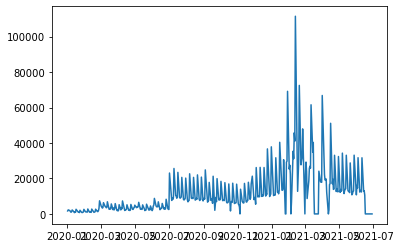

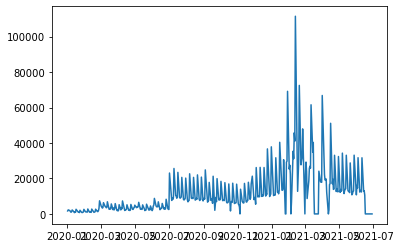

In [9]:
fig,ax = plt.subplots()

ax.plot(model_df['time'],model_df['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

fig,ax = plt.subplots()

ax.plot(model_df['time'],model_df['comment_count'] )



    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()



In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

import time
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [ ]:
results_df = pd.DataFrame(columns=['target','rmse','r2','start','mid','end','actual','predict'])

In [54]:
predict_df = pd.DataFrame(columns=['time','actual','predict'])

In [140]:
#//*** Lengthy K-Means Run. Runs a model on every day after 60+ and predicts the next day. Uses the previous 60 days to predict the next day. 
#//*** It may or may not be helpful to run k-means across the whole tfidf instead of the previous 60.

predict_df = pd.DataFrame(columns=['time','actual','predict','best_r'])

#//*** Loop through model_df. Model each day individually. Train 60 days, Predict 61.
training_days = 60
train_start_slice = 0
train_end_slice = training_days
cluster_iterations = 50
predict_col = [f'target_1']
train_cols = ['cluster_1','close','volume','open','high','low']
#Loop through combined 
for row_int in range(0,len(tdf)-training_days-1):
    
    
    #//*** Build the slice start index
    start_dex = train_start_slice+row_int
    
    #//*** Build the slice end index
    end_dex = train_end_slice+row_int
    
    dc = f"{start_dex}/{len(model_df)}"

    #//*** Build the sliced training df
    train_df = model_df[start_dex:end_dex].copy()

    tfidf = TfidfVectorizer()

    #print(dc, " Starting tfidf....")
    start_time = time.time()
    tfidf = TfidfVectorizer()
    train_tfidf = tfidf.fit_transform(train_df['body'])
    print(dc,f"tfidf Built: {round(time.time()-start_time,2)}s")
    
    
    #//*** Build the row index on the prediction (train_end_slice+1)
    predict_dex = row_int+train_end_slice+1
    
    #print("Starting K-Means...")
    offset=1
    best_r = 0
    best_cluster = []
    for x in range(1,cluster_iterations):

        start_time=time.time()
        kmeans = KMeans(n_clusters=5,init='random').fit(train_tfidf)
        cluster = kmeans.predict(train_tfidf)
        r,p = pearsonr(train_df[f'target_{offset}'],cluster)
        r = abs(r)
        #print(r,round(p,6))

        if p < .05:
            if r > best_r:
                best_r = r
                best_cluster = cluster
            #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
        if x == 1:
            print(dc,f"Estimated Cluster Run Time: {round( (time.time()-start_time)*cluster_iterations-1,2) }s")
    #print(f"Best R:{best_r}")
     
    train_df[f'cluster_{offset}'] = best_cluster

    
    x_train = np.array(train_df[train_cols])
    y_train = np.array(train_df[predict_col])

    x_test = pd.DataFrame(model_df.iloc[end_dex+1].copy()).transpose()
    
    x_test[f'cluster_{offset}'] = best_cluster[0]
    x_test = np.array(x_test[train_cols])
    

    y_test = model_df[predict_col].iloc[end_dex:end_dex+1]

    #regr_iter = 20

    start_time = time.time()

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(x_train, y_train)
    result = regr.predict(x_test)



    print(dc,f"[{result[0][0]}]  Actual: {model_df.iloc[predict_dex]['close']} - Best R2: {best_r}")
    
    
    #//*** Add Results to the predict_df
    predict_df.loc[len(predict_df)] = [model_df.iloc[predict_dex]['time'],model_df.iloc[predict_dex]['close'],result[0][0],best_r]

print("Done!")
predict_df

0/376 tfidf Built: 2.27s
0/376 Estimated Cluster Run Time: 13.61s
0/376 [3.3030201597985402]  Actual: 3.16 - Best R2: 0.5079286601564842
1/376 tfidf Built: 2.23s
1/376 Estimated Cluster Run Time: 14.08s
1/376 [3.069758103307027]  Actual: 2.62 - Best R2: 0.5151064650016545
2/376 tfidf Built: 2.21s
2/376 Estimated Cluster Run Time: 15.09s
2/376 [2.8683097445466927]  Actual: 2.24 - Best R2: 0.5164177491318698
3/376 tfidf Built: 2.25s
3/376 Estimated Cluster Run Time: 13.01s
3/376 [2.3382171527926605]  Actual: 2.27 - Best R2: 0.6624465285593784
4/376 tfidf Built: 2.26s
4/376 Estimated Cluster Run Time: 12.57s
4/376 [2.6581686751927767]  Actual: 2.88 - Best R2: 0.5171834529572015
5/376 tfidf Built: 2.28s
5/376 Estimated Cluster Run Time: 14.51s
5/376 [3.4403036239678224]  Actual: 3.14 - Best R2: 0.5626216477259991
6/376 tfidf Built: 2.26s
6/376 Estimated Cluster Run Time: 14.56s
6/376 [3.017401038844848]  Actual: 3.3 - Best R2: 0.5668097229421226
7/376 tfidf Built: 2.33s
7/376 Estimated Clu

59/376 [4.837508587900562]  Actual: 4.79 - Best R2: 0.7772397041177583
60/376 tfidf Built: 3.24s
60/376 Estimated Cluster Run Time: 18.1s
60/376 [4.438797628020671]  Actual: 4.27 - Best R2: 0.7666615566862102
61/376 tfidf Built: 3.25s
61/376 Estimated Cluster Run Time: 19.66s
61/376 [4.186382071624745]  Actual: 4.18 - Best R2: 0.7633724562757316
62/376 tfidf Built: 3.45s
62/376 Estimated Cluster Run Time: 16.99s
62/376 [4.027863256737463]  Actual: 4.42 - Best R2: 0.7156624362443225
63/376 tfidf Built: 3.4s
63/376 Estimated Cluster Run Time: 21.06s
63/376 [4.387995627422304]  Actual: 4.29 - Best R2: 0.7354079870019938
64/376 tfidf Built: 3.58s
64/376 Estimated Cluster Run Time: 18.14s
64/376 [4.391505673449636]  Actual: 4.57 - Best R2: 0.7271448630812621
65/376 tfidf Built: 3.45s
65/376 Estimated Cluster Run Time: 14.14s
65/376 [4.607775104320126]  Actual: 4.53 - Best R2: 0.7183281163137443
66/376 tfidf Built: 3.42s
66/376 Estimated Cluster Run Time: 17.05s
66/376 [4.583611960921335]  A

118/376 [5.761101762214486]  Actual: 5.72 - Best R2: 0.7307198409769063
119/376 tfidf Built: 10.51s
119/376 Estimated Cluster Run Time: 39.3s
119/376 [5.754220427871586]  Actual: 5.67 - Best R2: 0.8067803773079631
120/376 tfidf Built: 10.48s
120/376 Estimated Cluster Run Time: 41.83s
120/376 [5.427301027296393]  Actual: 5.32 - Best R2: 0.7141790276281059
121/376 tfidf Built: 11.3s
121/376 Estimated Cluster Run Time: 41.26s
121/376 [5.2916467097970425]  Actual: 5.21 - Best R2: 0.7936434957959234
122/376 tfidf Built: 10.83s
122/376 Estimated Cluster Run Time: 43.31s
122/376 [5.238446068779514]  Actual: 4.78 - Best R2: 0.7564223814556374
123/376 tfidf Built: 10.88s
123/376 Estimated Cluster Run Time: 40.69s
123/376 [4.776890886946044]  Actual: 4.61 - Best R2: 0.8189782459504484
124/376 tfidf Built: 11.1s
124/376 Estimated Cluster Run Time: 40.18s
124/376 [4.771508864467178]  Actual: 4.88 - Best R2: 0.7003799402461637
125/376 tfidf Built: 10.84s
125/376 Estimated Cluster Run Time: 35.76s
1

176/376 tfidf Built: 9.16s
176/376 Estimated Cluster Run Time: 31.7s
176/376 [4.217957259549657]  Actual: 3.86 - Best R2: 0.6613805617348751
177/376 tfidf Built: 9.13s
177/376 Estimated Cluster Run Time: 29.72s
177/376 [3.6670717376663906]  Actual: 4.09 - Best R2: 0.6442178382218686
178/376 tfidf Built: 9.12s
178/376 Estimated Cluster Run Time: 38.66s
178/376 [4.010087604018491]  Actual: 3.92 - Best R2: 0.6038589492647706
179/376 tfidf Built: 9.11s
179/376 Estimated Cluster Run Time: 39.19s
179/376 [3.5402214592430536]  Actual: 3.19 - Best R2: 0.6024406765235144
180/376 tfidf Built: 9.46s
180/376 Estimated Cluster Run Time: 43.39s
180/376 [2.9618968066565436]  Actual: 2.86 - Best R2: 0.6697360680360285
181/376 tfidf Built: 9.12s
181/376 Estimated Cluster Run Time: 36.88s
181/376 [2.690069089139934]  Actual: 2.78 - Best R2: 0.5016157444399364
182/376 tfidf Built: 9.28s
182/376 Estimated Cluster Run Time: 31.25s
182/376 [2.723222155059184]  Actual: 2.85 - Best R2: 0.6613783234058358
183/

233/376 [5.078252447640727]  Actual: 8.03 - Best R2: 0.600308897327385
234/376 tfidf Built: 18.93s
234/376 Estimated Cluster Run Time: 45.71s
234/376 [4.929267446809625]  Actual: 8.05 - Best R2: 0.6177905944284392
235/376 tfidf Built: 18.81s
235/376 Estimated Cluster Run Time: 64.97s
235/376 [5.421771429769077]  Actual: 9.29 - Best R2: 0.6057736215318261
236/376 tfidf Built: 18.82s
236/376 Estimated Cluster Run Time: 66.46s
236/376 [5.64600045417199]  Actual: 10.5 - Best R2: 0.6504942300518741
237/376 tfidf Built: 18.8s
237/376 Estimated Cluster Run Time: 62.8s
237/376 [9.596958864321653]  Actual: 9.85 - Best R2: 0.6203684735120445
238/376 tfidf Built: 19.15s
238/376 Estimated Cluster Run Time: 71.5s
238/376 [6.233800588819975]  Actual: 10.28 - Best R2: 0.6506981794458897
239/376 tfidf Built: 19.42s
239/376 Estimated Cluster Run Time: 59.36s
239/376 [5.684654436123598]  Actual: 11.16 - Best R2: 0.647589295808227
240/376 tfidf Built: 19.41s
240/376 Estimated Cluster Run Time: 62.85s
240

291/376 tfidf Built: 15.5s
291/376 Estimated Cluster Run Time: 61.86s
291/376 [16.904461533094445]  Actual: 19.56 - Best R2: 0.48177627421744196
292/376 tfidf Built: 15.64s
292/376 Estimated Cluster Run Time: 49.77s
292/376 [17.456605225954384]  Actual: 26.52 - Best R2: 0.5673915807099064
293/376 tfidf Built: 15.51s
293/376 Estimated Cluster Run Time: 53.36s
293/376 [31.316659373508777]  Actual: 26.12 - Best R2: 0.664105834776226
294/376 tfidf Built: 15.31s
294/376 Estimated Cluster Run Time: 72.54s
294/376 [32.12390558223123]  Actual: 32.04 - Best R2: 0.6619325547002857
295/376 tfidf Built: 15.46s
295/376 Estimated Cluster Run Time: 55.95s
295/376 [44.5178416550157]  Actual: 62.55 - Best R2: 0.598602403316359
296/376 tfidf Built: 16.21s
296/376 Estimated Cluster Run Time: 59.88s
296/376 [50.74506697330948]  Actual: 51.34 - Best R2: 0.5918893004380601
297/376 tfidf Built: 15.42s
297/376 Estimated Cluster Run Time: 64.87s
297/376 [39.05420853966555]  Actual: 47.91 - Best R2: 0.590617424

,time,actual,predict,best_r
0,2020-03-31,3.16,3.303020,0.507929
1,2020-04-01,2.62,3.069758,0.515106
2,2020-04-02,2.24,2.868310,0.516418
3,2020-04-03,2.27,2.338217,0.662447
4,2020-04-06,2.88,2.658169,0.517183
...,...,...,...,...
310,2021-06-23,58.30,56.069710,0.734418
311,2021-06-24,56.70,58.257921,0.647532
312,2021-06-25,54.06,55.182170,0.685044
313,2021-06-28,58.11,54.375516,0.744557


In [141]:
predict_df.to_csv("./results/amc_daily_60_to_1_model.csv",index=False)

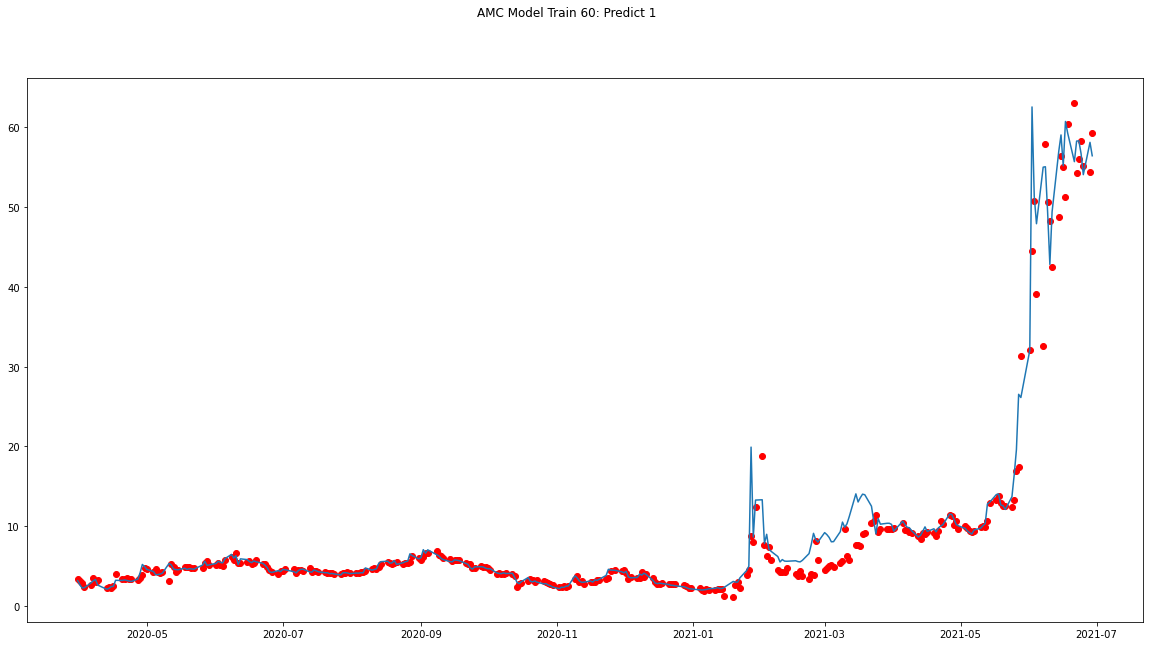

In [148]:
predict_df
fig,ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(y_test))
ax.plot(predict_df['time'],predict_df['actual'] )
ax.scatter(predict_df['time'],predict_df['predict'],color='red' )
plt.suptitle(f"AMC Model Train 60: Predict 1")
plt.show()

In [139]:
x_test = (model_df.iloc[end_dex+1].copy())
x_test = pd.DataFrame(model_df.iloc[end_dex+1].copy()).transpose()
x_test[f'cluster_{offset}'] = best_cluster[0]
#x_test = x_test.append( pd.Series(best_cluster[0], index = [f'cluster_{offset}']) )
x_test
x_train
x_train = np.array(train_df[train_cols].iloc[start_dex:end_dex])
y_train = np.array(train_df.iloc[start_dex:end_dex][predict_col],)
train_df


,time,symbol,open,high,low,close,volume,target_1,target_2,target_3,body,comment_count,cluster_1
1576,2020-03-30,amc,3.45,3.5000,3.0400,3.04,4217881,3.60,3.70,3.46,Depends on their ability to service debt and o...,1933,2
1577,2020-03-31,amc,3.15,3.2900,3.0800,3.16,3637052,3.04,3.60,3.70,Do you guys know why its up? I couldnt find an...,2109,2
1578,2020-04-01,amc,3.00,3.0400,2.5000,2.62,5874324,3.16,3.04,3.60,i did this. Sold half of my position at $7 to ...,1650,2
1579,2020-04-02,amc,2.74,2.7800,2.1800,2.24,8791588,2.62,3.16,3.04,You hate to see it 💀🤣 Hexo train gonna leave s...,2115,2
1580,2020-04-03,amc,2.32,2.3400,2.0000,2.27,7486013,2.24,2.62,3.16,"bro.. what can i say i love this guy, i wanna ...",5196,1
1581,2020-04-06,amc,2.50,2.9700,2.4000,2.88,6904947,2.27,2.24,2.62,Thank you so much for your response. I study s...,2263,3
1582,2020-04-07,amc,3.17,3.7300,3.0500,3.14,8971059,2.88,2.27,2.24,"I’m not your guy, friend. Been drinking a heft...",3561,3
1583,2020-04-08,amc,3.05,3.3200,2.8000,3.30,7992007,3.14,2.88,2.27,I bought at £85. Currently down about £200 tho...,2906,2
1584,2020-04-09,amc,3.30,3.3000,2.5800,2.60,13898977,3.30,3.14,2.88,Correction 47% up That was actually in my plan...,7322,1
1585,2020-04-13,amc,2.34,2.3600,1.9500,2.08,19747546,2.60,3.30,3.14,Lol I bought at 0.19 and sold at 0.70. Look i...,1915,3


In [ ]:
#//*** Train 60
#//*** Model 30
#//*** The Original K-Means Model


#//*** Divide up the data in 60 day intervals to predict the next 30 days
days = 30 
train_cols = ['cluster_1','close','volume','open','high','low']
cluster_iterations = 50


for index in range(2,int(len(tdf)/days)):
    
    min_slice = ((index-2)*days)
    mid_slice = index*days
    max_slice = (index*days)+days
    print(index,"Train Range:",min_slice,mid_slice," - Test Range:", mid_slice, max_slice  )
    
    train_df = tdf[min_slice:max_slice].copy()

    tfidf = TfidfVectorizer()

    print("Starting tfidf....")
    start_time = time.time()
    tfidf = TfidfVectorizer()
    train_tfidf = tfidf.fit_transform(train_df['body'])
    print(f"Built: {round(time.time()-start_time,2)}")
    
    print("Starting K-Means...")
    offset=1
    best_r = 0
    best_cluster = []
    for x in range(1,cluster_iterations):

        start_time=time.time()
        kmeans = KMeans(n_clusters=5,init='random').fit(train_tfidf)
        cluster = kmeans.predict(train_tfidf)
        r,p = pearsonr(train_df[f'target_{offset}'],cluster)
        r = abs(r)
        #print(r,round(p,6))

        if p < .05:
            if r > best_r:
                best_r = r
                best_cluster = cluster
            #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
        if x == 1:
            print(f"Estimated Cluster Run Time: {round( (time.time()-start_time)*cluster_iterations-1,2) }s")
    print(f"Best R:{best_r}")
    train_df[f'cluster_{offset}'] = best_cluster
    
     
    for tgt in [1,2,3,4,5,6,7,8,9,10]:
        predict_col = [f'target_{tgt}']
        x_train = np.array(train_df[train_cols].iloc[0:days*2*-1])
        y_train = np.array(train_df.iloc[0:days*2*-1][predict_col],)

        x_test = train_df[train_cols].iloc[days*2*-1:]
        y_test = train_df[predict_col].iloc[days*2*-1:]

        regr_iter = 20

        start_time = time.time()

        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(x_train, y_train)
        result = regr.predict(x_test)

        mse = mean_squared_error(y_test, result)
        r2 = r2_score(y_test,result)
        
        #//*** Root Mean squared Error
        rmse = sqrt(mse)

        # Plot outputs
        display_size = 40

        fig,ax = plt.subplots()
        plot_x = np.arange(len(y_test))
        ax.plot(plot_x,y_test )
        ax.scatter(plot_x,result,color='red' )
        plt.suptitle(f"{predict_col}\nRmse: {rmse} - r2 {r2}")
        plt.show()
        
        

        #print(rmse)
        #print(result)

        #//*** Update Results_df
        results_df.loc[len(results_df)] = [predict_col[0],rmse,r2,min_slice,mid_slice,max_slice,np.array(y_test),result]
print('done')

In [ ]:
results_df

In [ ]:
#results_df.to_pickle("./results_amc_daily_kmeans_ols.pkl")


In [12]:
print(model_df)
tfidf = TfidfVectorizer()
whole_tfidf = tfidf.fit_transform(model_df['body'])
whole_tfidf

           time symbol   open   high     low  close     volume  target_1  \
1516 2020-01-02    amc   7.30   7.56   7.230   7.46    4545935      7.24   
1517 2020-01-03    amc   7.45   7.60   7.305   7.32    2217959      7.46   
1518 2020-01-06    amc   7.25   7.30   7.110   7.12    2903381      7.32   
1519 2020-01-07    amc   7.11   7.20   7.000   7.13    3206587      7.12   
1520 2020-01-08    amc   7.11   7.15   6.610   6.62    6556979      7.13   
...         ...    ...    ...    ...     ...    ...        ...       ...   
1887 2021-06-23    amc  57.04  61.10  56.800  58.30  116291804     58.27   
1888 2021-06-24    amc  57.98  58.76  55.660  56.70   80351219     58.30   
1889 2021-06-25    amc  55.75  56.29  52.970  54.06   77596927     56.70   
1890 2021-06-28    amc  55.10  59.36  54.330  58.11   99310240     54.06   
1891 2021-06-29    amc  59.06  61.00  56.180  56.43   63604135     58.11   

      target_2  target_3                                               body  \
1516    

<376x464300 sparse matrix of type '<class 'numpy.float64'>'
	with 5137042 stored elements in Compressed Sparse Row format>

In [178]:
t = whole_tfidf.toarray()


376

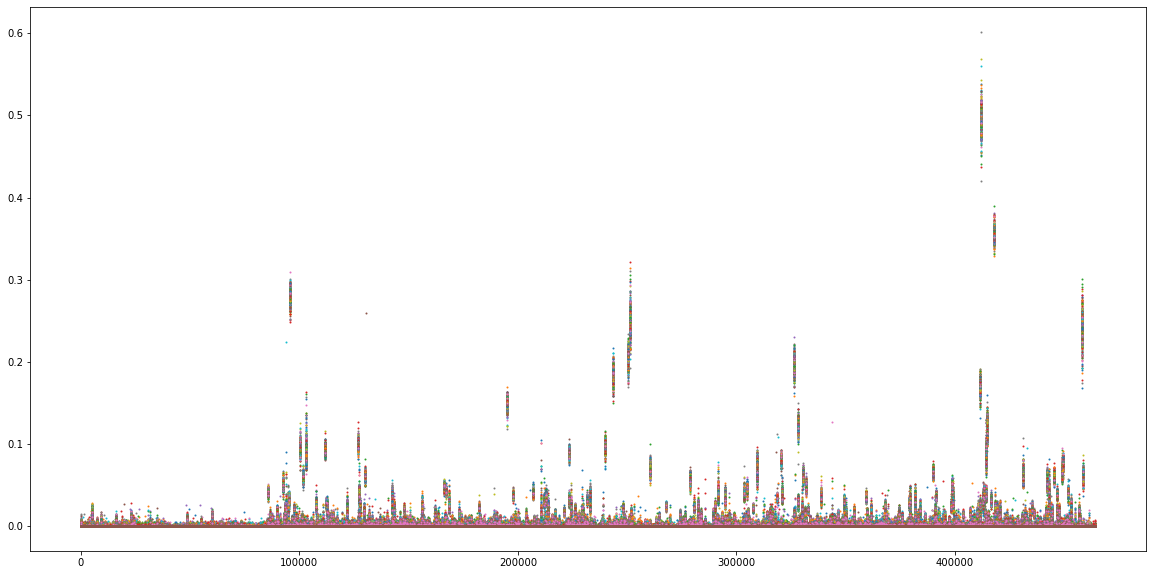

In [179]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(t[0]))
for x in t:
    ax.scatter(plot_x,x,s=1 )
plt.show()

In [241]:
vocab_df = pd.DataFrame()
vocab_df['word'] = tfidf.vocabulary_
vocab_df['score'] = tfidf.idf_

In [217]:
tfidf_df = pd.DataFrame(whole_tfidf.toarray())
tfidf_df.columns = tfidf.vocabulary_

#tfidf_df[tfidf_df.columns[:10]]


list(vocab_df.sort_values('score',ascending=True)['word'])
#tfidf_df.columns = (range(len(tfidf_df.columns)))
tfidf_df[tfidf_df.columns[:10]]

,hyperemesis,408000,mayweathee,ernestspacleton,nebelungpixie,itshow,rrsrjyywy6y,wspd,2fnzvkeh,vlan
0,0.001676,0.005364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002035,0.007009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003197,0.007131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.006420,0.002703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001483,0.008529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
371,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
vocab_df = pd.DataFrame()
vocab_df['word'] = tfidf.vocabulary_
vocab_df['score'] = tfidf.idf_
tfidf_df = pd.DataFrame(whole_tfidf.toarray())
ascending_vals = list(tfidf_df.sum().sort_values(ascending=True).index)
descending_vals = list(tfidf_df.sum().sort_values(ascending=False).index)
vocab_vals = list(vocab_df.sort_values('score',ascending=True)['word'])

In [156]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(3)
tsvd_df = pd.DataFrame(tsvd.fit_transform(tfidf_df[descending_vals[:100]]))
print(tsvd.explained_variance_ratio_.sum())
tsvd_df**2

0.9630669373220283


,0,1,2
0,0.944902,0.003218,0.000051
1,0.956776,0.000952,0.000319
2,0.954054,0.000720,0.000026
3,0.950444,0.000595,0.000076
4,0.944014,0.003007,0.002284
...,...,...,...
371,0.000000,0.000000,0.000000
372,0.000000,0.000000,0.000000
373,0.000000,0.000000,0.000000
374,0.000000,0.000000,0.000000


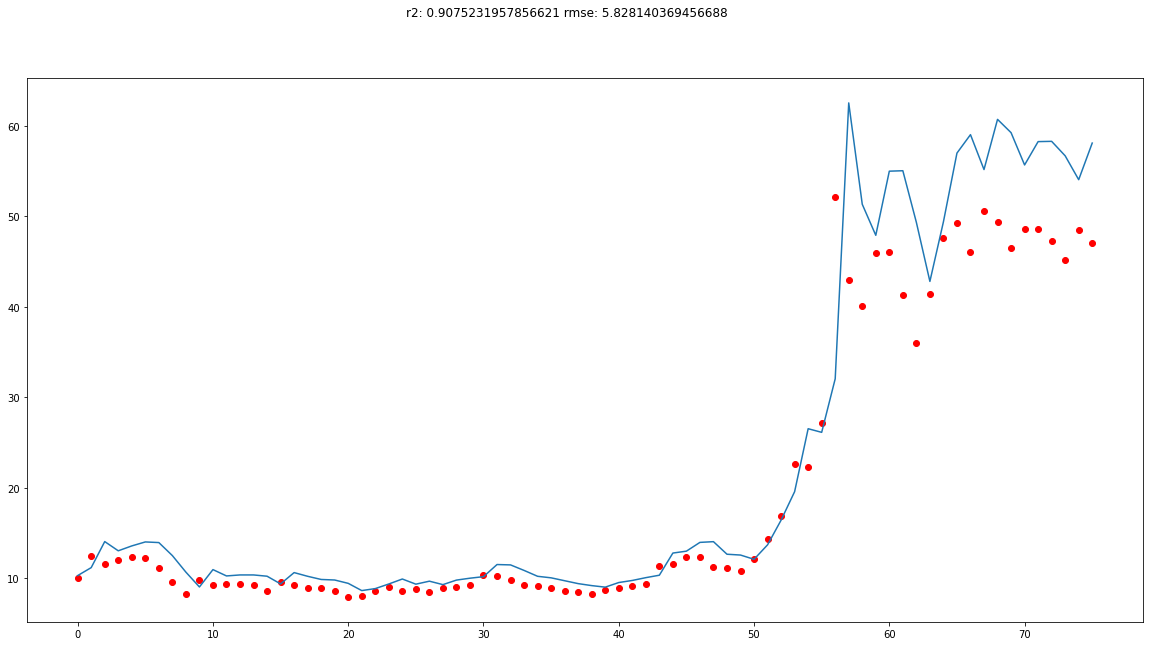

In [161]:
from sklearn.model_selection import train_test_split

tfidf_df[descending_vals[:1000]]

train_stock_cols = ['close','volume','open','high','low']
train_stock_cols = ['close']
model_df.reset_index(drop=True,inplace=True)

#//*** Combine the model columns for training with the tfidf columns
X = np.array(pd.concat([model_df[train_stock_cols],tfidf_df[descending_vals[:100]]],ignore_index=True,axis=1))
X = np.array(pd.concat([model_df[train_stock_cols],tsvd_df],ignore_index=True,axis=1))
X = np.array(pd.concat([tsvd_df**2,model_df[train_stock_cols]],ignore_index=True,axis=1))
#X = model_df[train_stock_cols]
y = model_df['target_1']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)
result = regr.predict(x_test)

mse = mean_squared_error(y_test, result)
r2 = r2_score(y_test,result)

#//*** Root Mean squared Error
rmse = sqrt(mse)



fig,ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(y_test))
ax.plot(plot_x,y_test )
ax.scatter(plot_x,result,color='red' )
#ax.scatter(predict_df['time'],predict_df['predict'],color='red' )
plt.suptitle(f"r2: {r2} rmse: {rmse}")
plt.show()

In [26]:

x_test = pd.DataFrame(model_df.iloc[end_dex+1].copy()).transpose()

x_test[f'cluster_{offset}'] = best_cluster[0]
x_test = np.array(x_test[train_cols])





y_test = model_df[predict_col].iloc[end_dex:end_dex+1]

#regr_iter = 20

start_time = time.time()




,411702,418047,95679,251354,458215,250256,326260,243276,411433,195013,327950,414512,126858,239904,100307,111655,103150,223569,413996,320379,449591,260471,309428,448754,390125,330420,458469,129944,101678,431166,445138,278727,442154,92353,166062,304895,331923,413401,398660,167298,85746,207116,451544,291730,127255,303621,414312,446556,197841,391140,320946,359448,443042,412876,294540,318777,338627,95276,212950,223266,231641,328082,416517,233097,399106,142452,212480,413093,211861,349075,379315,381656,112195,378814,127901,112520,328350,411271,412973,267682,168439,282551,107793,290031,182335,94968,93226,398290,367876,307525,247853,97491,280622,447822,226135,155938,435221,446921,143371,147696
0,0.476777,0.365440,0.262461,0.274832,0.252765,0.187568,0.177872,0.184224,0.179878,0.153130,0.116018,0.132735,0.102310,0.090942,0.085927,0.084924,0.126383,0.085592,0.074559,0.084924,0.070547,0.065866,0.053830,0.069544,0.072219,0.060182,0.059514,0.055167,0.066535,0.072219,0.066200,0.051824,0.048146,0.046140,0.053495,0.038784,0.053830,0.040790,0.053161,0.039118,0.040456,0.046140,0.045471,0.048814,0.037112,0.044134,0.035775,0.039118,0.031428,0.039453,0.036109,0.035106,0.043799,0.022401,0.033769,0.032766,0.041793,0.026079,0.034438,0.032766,0.038450,0.030760,0.034772,0.031428,0.023070,0.031094,0.030760,0.032097,0.036778,0.027082,0.037112,0.032766,0.031094,0.024742,0.025410,0.030425,0.025745,0.019726,0.020729,0.023739,0.033435,0.024742,0.030091,0.025410,0.019058,0.020061,0.020729,0.026413,0.028085,0.027416,0.022401,0.017720,0.026079,0.023070,0.027751,0.035106,0.023070,0.016383,0.010699,0.023404
1,0.494997,0.356308,0.261593,0.271515,0.241748,0.188978,0.195969,0.186498,0.167329,0.149514,0.112981,0.144778,0.101254,0.094264,0.095391,0.101254,0.112530,0.087047,0.100127,0.073066,0.067879,0.073066,0.055250,0.077801,0.067653,0.059986,0.050514,0.063369,0.052995,0.057280,0.069006,0.050063,0.064722,0.047132,0.054123,0.043298,0.054123,0.042396,0.039239,0.043749,0.040366,0.041269,0.040366,0.047132,0.041945,0.030670,0.037660,0.038337,0.037209,0.031121,0.045779,0.040818,0.047808,0.039690,0.027512,0.035856,0.040141,0.031797,0.036307,0.027963,0.032699,0.026159,0.038562,0.026159,0.023002,0.024130,0.039690,0.030895,0.033827,0.029542,0.022551,0.019845,0.030895,0.029767,0.025483,0.022777,0.025708,0.019394,0.030895,0.028189,0.032699,0.027512,0.024355,0.025257,0.021198,0.017590,0.019619,0.024130,0.022551,0.019168,0.022326,0.023228,0.026836,0.021424,0.018717,0.019394,0.019394,0.015560,0.017139,0.018041
2,0.487322,0.353903,0.277138,0.267819,0.255801,0.195714,0.197430,0.178791,0.178546,0.142738,0.114779,0.124344,0.092216,0.095895,0.079463,0.098102,0.116006,0.083877,0.101045,0.082406,0.067445,0.073822,0.045127,0.077746,0.062295,0.061804,0.066219,0.060578,0.058861,0.059106,0.059842,0.049051,0.055918,0.047089,0.045617,0.039731,0.049296,0.038996,0.040222,0.040958,0.044636,0.039731,0.046353,0.045617,0.044391,0.046108,0.035807,0.042674,0.034826,0.030412,0.040467,0.040222,0.037769,0.030166,0.026488,0.034090,0.032128,0.027223,0.025507,0.029921,0.043901,0.022563,0.031638,0.022073,0.020111,0.022563,0.029921,0.031883,0.031638,0.036788,0.048315,0.030166,0.026488,0.029185,0.027959,0.026978,0.024035,0.025752,0.026733,0.023054,0.040222,0.023790,0.022809,0.027469,0.022073,0.027469,0.024771,0.030166,0.027714,0.023544,0.018885,0.021582,0.029185,0.020111,0.017413,0.027714,0.017658,0.022318,0.017658,0.024035
3,0.500124,0.377115,0.250399,0.261858,0.239952,0.184008,0.185019,0.180638,0.146263,0.155362,0.112899,0.111551,0.113236,0.106158,0.093689,0.099755,0.113910,0.091330,0.110540,0.081220,0.068413,0.057629,0.048530,0.082568,0.071109,0.063695,0.054933,0.058640,0.062347,0.068413,0.065717,0.052574,0.044148,0.043137,0.052237,0.043474,0.050889,0.039093,0.039093,0.046845,0.037071,0.041115,0.038082,0.040441,0.037408,0.036734,0.045834,0.039093,0.041115,0.035386,0.043137,0.038756,0.035386,0.038082,0.023591,0.030331,0.029657,0.036397,0.034038,0.027635,0.035723,0.026624,0.037408,0.025276,0.015840,0.025276,0.04

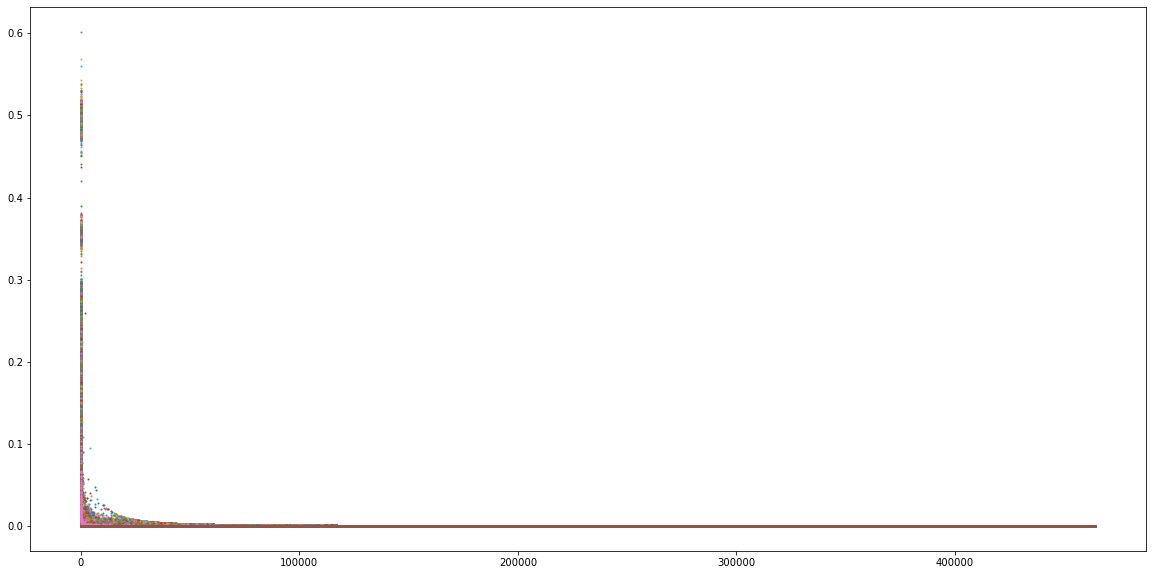

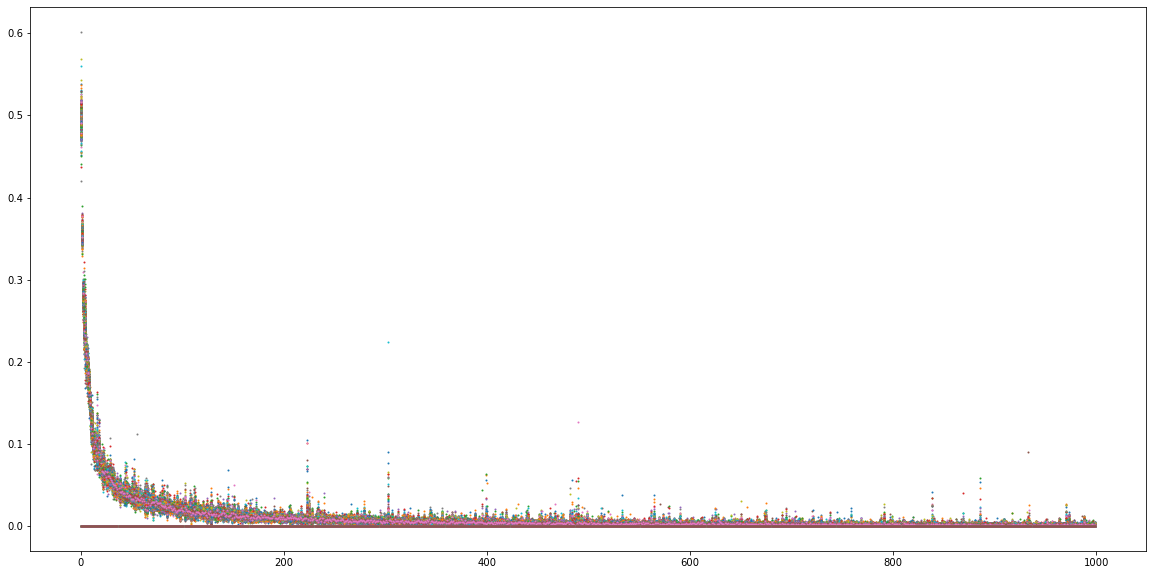

In [15]:
plot_df = tfidf_df[descending_vals]
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns))
for x in range(len(plot_df)):
    ax.scatter(plot_x,plot_df.iloc[x],s=1 )
plt.show()


fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns[:1000]))
for x in range(len(plot_df)):
    ax.scatter(plot_x,plot_df[plot_df.columns[:1000]].iloc[x],s=1 )
plt.show()

In [265]:
for x in plot_df[plot_df.columns[:100]]:
    print(x)

650s
thevintagenews
wnw
braves
jesbaek
ceo_of_notfunny
orthodontist
delta_echo_21
kbwy
peart
naked_puts_and_covered_calls_on_leveraged_etfs
follars
122679606
000119312521154788
rldl
uktvr
230km
0ahukewj2oq20qkfpahxqxc0khemca_gq4dudcas
why_isnt_your_vertical_spread_at_max_value
diversionary
krakauer
k3kqb2r
o0l7dw
hunter11142
_1100
2ftnxp_now_has_a_target_price_of_4
booyaa
20fucking20
kf5qvr
assume_deer_dead
bitcoincash
50c
cuteee
h755mjk
weaponizing
trivializes
slecht
zad
everyone_in_this_sub_when_they_speak_to_their_irl
49k
comoetitive
diacussions
allotcbb
grafts
eerhhhmghurd
politispac
55buy
2damf
spy440
hig
fzie6gx
dandys
scarysmoothcorydorascatfish
20however
statecouncil
n4b0jm
thatyou
agj5qgko3zmcw7n1urodzwfwefjvjzxzrsfjix4
intuned
o8q2wl
thusday
effingapp
fuckmaster
vtech
mfka
87trillion
ntp
vehcicles
precous
fransisco
iirs
yeast
n9udb1
50w
professional_emu
should_i_start_investing
secks
outpaces
bunts
be_on_the_right_side_of_history_my_respect_for
somenody
oa8wkz0ugle
tilisvigar

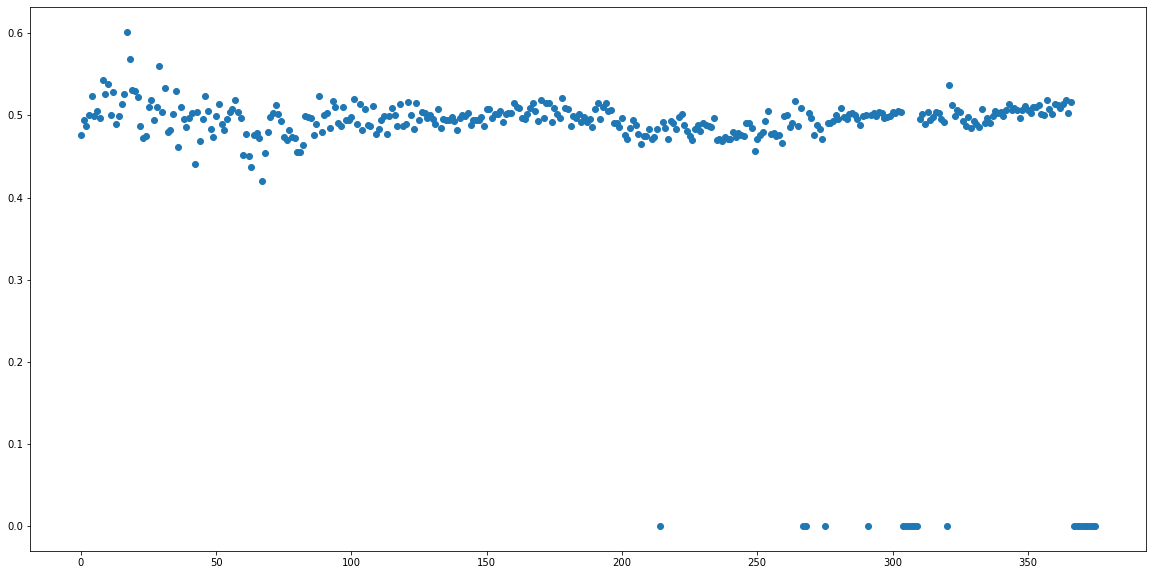

In [263]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns))
ax.scatter(plot_df.index,plot_df[plot_df.columns[0]])
plt.show()

In [ ]:
plot_df = tfidf_df[vocab_vals]
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(plot_df.columns))
for x in range(len(plot_df)):
    ax.scatter(plot_x,plot_df.iloc[x],s=1 )
plt.show()

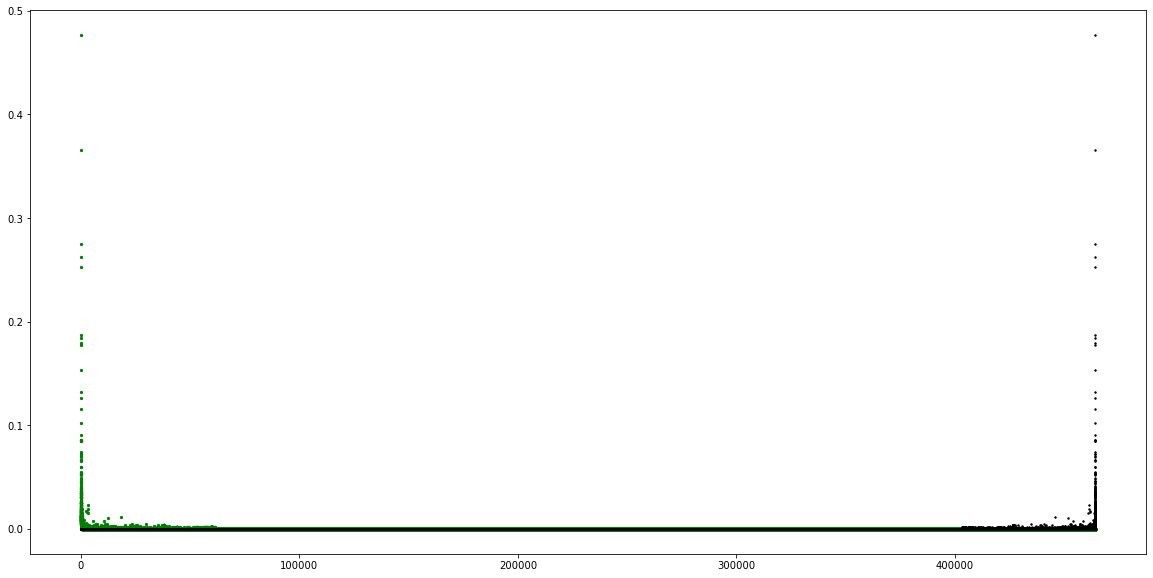

In [240]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plot_x = np.arange(len(tfidf_df.columns))

#for x in range(len(tfidf_df)):
ax.scatter(plot_x,tfidf_df.iloc[0][descending_vals],s=5,color='green' )
#tfidf_df.columns = tfidf_df.sum().sort_values(ascending=True).index
ax.scatter(plot_x,tfidf_df.iloc[0][ascending_vals],s=2,color='black' )
plt.show()

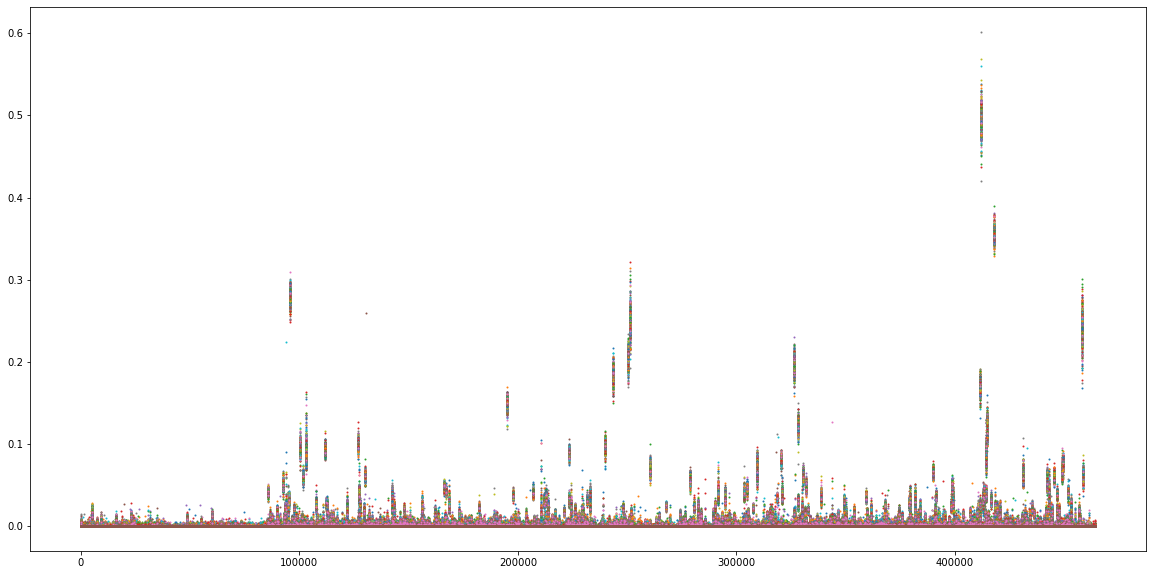

In [218]:
display_size = 40

fig,ax = plt.subplots()
fig.set_figheight(100)
fig.set_figwidth(200)
plot_x = np.arange(len(tfidf_df.columns))
for x in range(len(tfidf_df)):
    ax.scatter(plot_x,tfidf_df.iloc[x],s=1 )
plt.show()

In [ ]:
"""

print("Finding best cluster for classification")

train_slice = (270,300)
train_interval = 10

cluster_iterations = 50

train_df = tdf[train_slice[0]:train_slice[1]+train_interval].copy()

tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train_df['body'])


print(f"Built: {round(time.time()-start_time,2)}")
print("Starting K-Means...")
offset=1
best_r = 0
best_cluster = []
for x in range(1,cluster_iterations):
    
    start_time=time.time()
    kmeans = KMeans(n_clusters=5,init='random').fit(train_tfidf)
    cluster = kmeans.predict(train_tfidf)
    r,p = pearsonr(train_df[f'target_{offset}'],cluster)
    r = abs(r)
    #print(r,round(p,6))
    
    if p < .05:
        if r > best_r:
            best_r = r
            best_cluster = cluster
        #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
    if x == 1:
        print(f"Estimated Cluster Run Time: {round( (time.time()-start_time)*cluster_iterations-1,2) }s")
print(best_r,best_cluster)
train_df[f'cluster_{offset}'] = best_cluster
train_df
   
   """
print()

In [ ]:
 
"""

train_cols = ['cluster_1','close','volume','open','high','low']
predict_col = ['target_1']
x_train = np.array(train_df[train_cols].iloc[0:train_interval*-1])
y_train = np.array(train_df.iloc[0:train_interval*-1][predict_col],)

x_test = train_df[train_cols].iloc[train_interval*-1:]
y_test = train_df[predict_col].iloc[train_interval*-1:]


import time
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

regr_iter = 20

start_time = time.time()

print("Regressing")


#regr = MLPRegressor(max_iter=50000).fit(x_train,y_train)
#scores = cross_val_score(regr, x_train, y_train, cv=5)
print(f"Complete: {round(time.time()-start_time,2)}" )
#//*** Score the model
#score = regr.score(x_train, y_train)
#result = regr.predict(x_test)


# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)
result = regr.predict(x_test)
# Plot outputs
display_size = 40

fig,ax = plt.subplots()
plot_x = np.arange(len(y_test))
ax.plot(plot_x,y_test )
ax.scatter(plot_x,result,color='red' )

plt.show()
mse = mean_squared_error(y_test, result)

#//*** Root Mean squared Error
rmse = sqrt(mse)

print(rmse)
print(result)

"""

In [ ]:
#//***Aggreate Comments for Training
#//*** Build tfidf
from sklearn.feature_extraction.text import TfidfVectorizer


#loop_list.append(tfidf.fit_transform(input_df['tfidf']))
tfidf_matrix = []
tfidf_list = []
tfidf = TfidfVectorizer()

print("Starting tfidf....")
start_time = time.time()
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(tdf['body'])


print(f"Built: {round(time.time()-start_time,2)}")

print(tfidf_matrix)
print

In [ ]:
"""
#//*** Build TruncatedSVD

#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import TruncatedSVD

start_time = time.time()
print(f"Begin Truncated SVD ")

start_time=time.time()
#//*** Set the number of components to 6000. This is generating 98% variance capture
#//*** 60min data set took around 25minutes to build
tsvd = TruncatedSVD(250)
tsvd_df = pd.DataFrame(tsvd.fit_transform(tfidf_matrix))
print(tsvd.explained_variance_ratio_.sum())

print (f"Truncated SVD Done: {round(time.time()-start_time,2)}s")
#output_filename = './ignore_folder/tsvd_model_ready_daily.csv.zip'
#//*** Write Truncated SVD to disk
#tsvd_df.to_csv(output_filename, compression='zip', index=False)
"""
print("Truncated SVD Code")

LTSM: https://www.datacamp.com/community/tutorials/lstm-python-stock-market


In [ ]:
import time
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [ ]:
tsvd_df

In [ ]:
fig,ax = plt.subplots()

for col in tsvd_df.columns:

    ax.scatter(tsvd_df[col],tsvd_df.index,label=col )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
        curr_center = centroids[pred_clusters[i]]
        curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
    return sse

dir(tfidf_matrix)
#kmeans = KMeans(n_clusters=2).fit(tfidf_matrix)
dir(kmeans)
kmeans.score(tfidf_matrix)
k_scores = []
for x in [5,10,15,20,25,50]:
    start_time=time.time()
    kmeans = KMeans(n_clusters=x).fit(tfidf_matrix)
    loop_score = kmeans.score(tfidf_matrix)
    print(f"{x} - {loop_score} - {time.time()-start_time}s")
    k_scores.append(loop_score)
print(k_scores)

In [ ]:
fig,ax = plt.subplots()

ax.plot(range(len(k_scores)),k_scores )


    #plt.legend(loc='upper right',bbox_to_anchor=(1.35, 1.2))
plt.show()

Kmeans + Mean Shift: https://jamesxli.blogspot.com/2012/03/on-mean-shift-and-k-means-clustering.html


In [ ]:
dir(kmeans)